In [16]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
from tqdm import tqdm
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal.windows import flattop

In [156]:
cic_i_lib = ctypes.CDLL('./cic4d128_i.so')
cic_i_lib.cic4d128.argtypes = [ctypes.c_uint64]
cic_i_lib.cic4d128.restype = ctypes.POINTER(ctypes.c_int64)

cic_q_lib = ctypes.CDLL('./cic4d128_q.so')
cic_q_lib.cic4d128.argtypes = [ctypes.c_uint64]
cic_q_lib.cic4d128.restype = ctypes.POINTER(ctypes.c_int64)

fir_i_lib = ctypes.CDLL('./cic4d128comp_i.so')
fir_i_lib.firCIC4D128Comp64.argtypes = [ctypes.c_int64, ctypes.c_int64]
fir_i_lib.firCIC4D128Comp64.restype = ctypes.POINTER(ctypes.c_int64)

fir_q_lib = ctypes.CDLL('./cic4d128comp_q.so')
fir_q_lib.firCIC4D128Comp64.argtypes = [ctypes.c_int64, ctypes.c_int64]
fir_q_lib.firCIC4D128Comp64.restype = ctypes.POINTER(ctypes.c_int64)

mixer_i_lib = ctypes.CDLL('./mixer_i.so')
mixer_i_lib.mixer.argtypes = [ctypes.c_int64, ctypes.c_int64]
mixer_i_lib.mixer.restype = ctypes.POINTER(ctypes.c_int64)

mixer_q_lib = ctypes.CDLL('./mixer_q.so')
mixer_q_lib.mixer.argtypes = [ctypes.c_int64, ctypes.c_int64]
mixer_q_lib.mixer.restype = ctypes.POINTER(ctypes.c_int64)

nco_lib = ctypes.CDLL('./nco.so')
nco_lib.nco.argtypes = [ctypes.c_uint64]
nco_lib.nco.restype = ctypes.POINTER(ctypes.c_int64)

idxDec_lib = ctypes.CDLL('./idxDec_i.so')
idxDec_lib.idxDec.argtypes = [ctypes.c_int64]
idxDec_lib.idxDec.restype = ctypes.POINTER(ctypes.c_int64)

lutDec_lib = ctypes.CDLL('./lutDec_i.so')
lutDec_lib.lutDec.argtypes = [ctypes.c_int64, ctypes.c_int64]
lutDec_lib.lutDec.restype = ctypes.POINTER(ctypes.c_int64)

lut_data = np.int64((np.sin(np.linspace(0, 1, 2**12) * np.pi/2)) * (2**17 - 1))

def decode(idx: np.int64):
    idx_ptr = idxDec_lib.idxDec(idx)
    out_ptr = lutDec_lib.lutDec(idx, lut_data[idx_ptr[0]])
    return out_ptr[0]

In [186]:
len(lut_data), np.max(lut_data)

(4096, np.int64(131071))

In [184]:
with open("lut_data_18.coe", "w") as f:
    f.write("memory_initialization_radix=10;\n")
    f.write("memory_initialization_vector=\n")
    for i in range(len(lut_data)):
        f.write("{}{}".format(lut_data[i], "," if i < len(lut_data)-1 else ";"))
        f.write("\n")

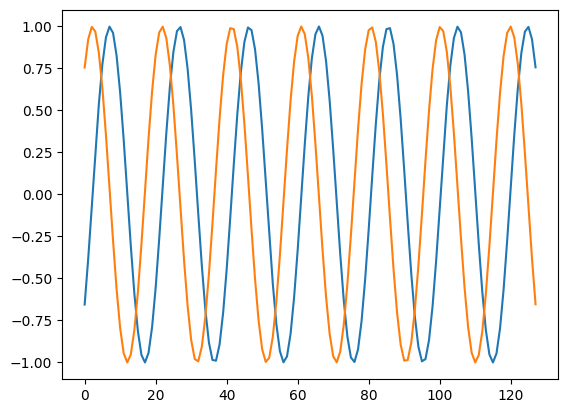

In [157]:
n_samples = 8197
fs = 122.88e6
freq = fs/20 + 123e3
tw = int((freq / fs) * (2**24))

out_i = np.zeros(n_samples, dtype=np.int64)
out_q = np.zeros(n_samples, dtype=np.int64)

for i in range(n_samples):
    out_ptr = nco_lib.nco(tw)
    out_i[i] = decode(out_ptr[0])
    out_q[i] = decode(out_ptr[1])

plt.plot(out_i[:128]/(2**17 - 1))
plt.plot(out_q[:128]/(2**17 - 1))

100%|██████████| 1024/1024 [07:00<00:00,  2.44it/s]


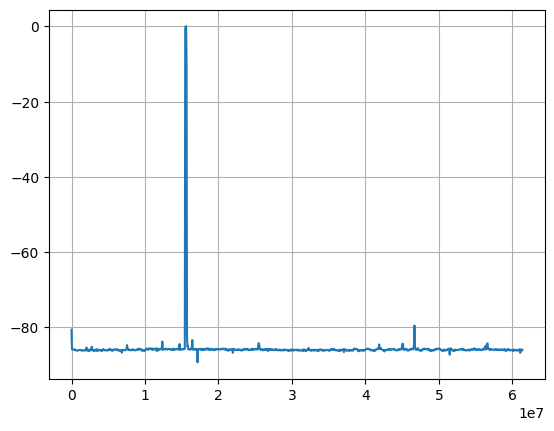

In [167]:
fs = 122.88e6 # Sampling frequency
ts = 1/fs   # Sampling period

lo_freq = 15.56e6
lo_tw = int((lo_freq / fs) * (2**24))

freqs_to_scan = np.arange(0, fs/2, ((fs/2)/1024))

attenuation_dbs = []

for freq in tqdm(freqs_to_scan):
    
    # sample at least 2 periods of the signal
    signal_length = int(2 * (1/np.abs(freq - lo_freq)) * fs) 
    signal_length = signal_length if signal_length > 65536 else 65536

    mixer_i = mixer_i_lib.mixer
    mixer_q = mixer_q_lib.mixer
    cic_i   = cic_i_lib.cic4d128
    fir_i   = fir_i_lib.firCIC4D128Comp64
    cic_q   = cic_q_lib.cic4d128
    fir_q   = fir_q_lib.firCIC4D128Comp64
    nco     = nco_lib.nco
    
    signal = np.sin(2 * np.pi * freq * np.arange(signal_length) * ts + 0.3, dtype=np.float64)

    signal_int = (signal * (2**15 - 1)).astype(np.int64)

    signal_i_filtered = np.zeros_like(signal, dtype=np.int64)
    signal_q_filtered = np.zeros_like(signal, dtype=np.int64)
    signal_i_valid    = np.zeros_like(signal, dtype=bool)
    signal_q_valid    = np.zeros_like(signal, dtype=bool)

    for i, sig in enumerate(signal_int):
        nco_ptr = nco(lo_tw)

        lo_i = decode(nco_ptr[0])
        lo_q = decode(nco_ptr[1])

        res_ptr = mixer_i(lo_i, sig)
        mixed_i = res_ptr[0] >> (34 - 15)

        res_ptr = mixer_q(lo_q, sig)
        mixed_q = res_ptr[0] >> (34 - 15)

        # i channel
        res_ptr1 = cic_i(mixed_i) 
        cic_i_out_valid = res_ptr1[0]
        cic_i_out = res_ptr1[1] # >> (37-18)
        
        res_ptr2 = fir_i(cic_i_out_valid, cic_i_out)
        fir_i_out_valid = res_ptr2[0]
        fir_i_out = res_ptr2[1]

        # q channel
        res_ptr3 = cic_q(mixed_q)
        cic_q_out_valid = res_ptr3[0]
        cic_q_out = res_ptr3[1]

        res_ptr4 = fir_q(cic_q_out_valid, cic_q_out)
        fir_q_out_valid = res_ptr4[0]
        fir_q_out = res_ptr4[1]

        # res_ptr3 = decimator_lib.decimator2(fir_out_valid, fir_out)
        # dec_out_valid = res_ptr3[0]
        # dec_out = res_ptr3[1]
        # dec_out = dec_out >> (36-18)

        # res_ptr4 = lpf_lib.lpf_03125_05(dec_out_valid, dec_out)
        # lpf_out_valid = res_ptr4[0] == -1
        # lpf_out = res_ptr4[1]

        signal_i_filtered[i] = fir_i_out
        signal_i_valid[i]    = fir_i_out_valid
        signal_q_filtered[i] = fir_q_out
        signal_q_valid[i]    = fir_q_out_valid
    
    signal_i_filtered = signal_i_filtered[signal_i_valid] / (2**34)
    signal_q_filtered = signal_q_filtered[signal_q_valid] / (2**34)
    signal_i_filtered = signal_i_filtered[64:]
    signal_q_filtered = signal_q_filtered[64:]

    signal_filtered = signal_i_filtered + 1j * signal_q_filtered

    # signal_filtered = signal_filtered[signal_valid] / (2**33)
    # signal_filtered = signal_filtered[64:]


    # raise error for debugging
    # raise ValueError("Debugging stop")

    # get peak-peak amplitude of the filtered signal and the original signal
    # filtered_peak = np.max(signal_i_filtered) - np.min(signal_i_filtered)
    # signal_peak = np.max(signal) - np.min(signal)

    filtered_peak =  np.max(np.abs(fft(signal_filtered * flattop(len(signal_filtered)))) * (2.0/len(signal_filtered)))
    signal_peak = np.max(np.abs(fft(signal * flattop(len(signal)))) * (2.0/len(signal)))
    attenuation_db = 20 * np.log10(filtered_peak / signal_peak)
    attenuation_dbs.append(attenuation_db)

attenuation_dbs = np.array(attenuation_dbs)

plt.grid()
plt.plot(freqs_to_scan, attenuation_dbs)


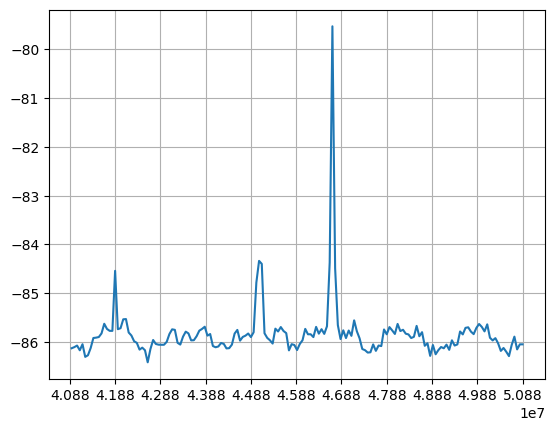

In [172]:
freq_l = (61.44e6 - lo_freq) - 5e6
freq_h = (61.44e6 - lo_freq) + 5e6
plt.grid()
plt.xticks(np.arange(freq_l, freq_h+1, 1e6))
plt.plot(freqs_to_scan[(freqs_to_scan >= freq_l) & (freqs_to_scan <= freq_h)], attenuation_dbs[(freqs_to_scan >= freq_l) & (freqs_to_scan <= freq_h)])

In [175]:
ddc_branch_i_lib = ctypes.CDLL('./ddc_branch_i.so')
ddc_branch_i_lib.ddc_branch.argtypes = [ctypes.c_int64, ctypes.c_int64]
ddc_branch_i_lib.ddc_branch.restype = ctypes.POINTER(ctypes.c_int64)

ddc_branch_q_lib = ctypes.CDLL('./ddc_branch_q.so')
ddc_branch_q_lib.ddc_branch.argtypes = [ctypes.c_int64, ctypes.c_int64]
ddc_branch_q_lib.ddc_branch.restype = ctypes.POINTER(ctypes.c_int64)

ddc_lib = ctypes.CDLL('./ddc.so')
ddc_lib.ddc.argtypes = [ctypes.c_int64, ctypes.c_int64, ctypes.c_int64]
ddc_lib.ddc.restype = ctypes.POINTER(ctypes.c_int64)

100%|██████████| 8192/8192 [43:22<00:00,  3.15it/s]


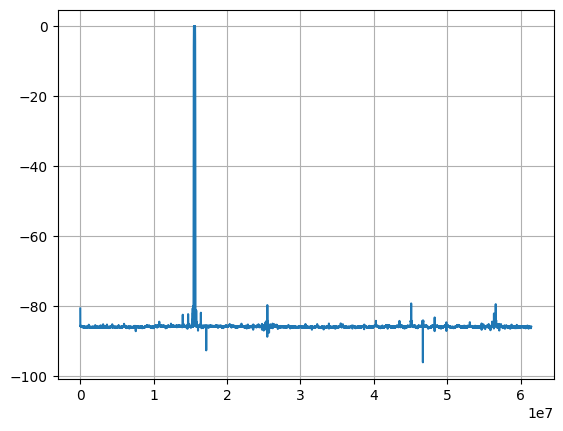

In [ ]:
fs = 122.88e6 # Sampling frequency
ts = 1/fs   # Sampling period

lo_freq = 15.56e6
lo_tw = int((lo_freq / fs) * (2**24))

freqs_to_scan = np.arange(0, fs/2, ((fs/2)/1024))

attenuation_dbs = []

for freq in tqdm(freqs_to_scan):
    
    # sample at least 2 periods of the signal
    signal_length = int(2 * (1/np.abs(freq - lo_freq)) * fs) 
    signal_length = signal_length if signal_length > 65536 else 65536

    ddc = ddc_lib.ddc
    nco     = nco_lib.nco
    
    signal = np.sin(2 * np.pi * freq * np.arange(signal_length) * ts + 0.3, dtype=np.float64)

    signal_int = (signal * (2**15 - 1)).astype(np.int64)

    signal_i_filtered = np.zeros_like(signal, dtype=np.int64)
    signal_q_filtered = np.zeros_like(signal, dtype=np.int64)
    signal_i_valid    = np.zeros_like(signal, dtype=bool)
    signal_q_valid    = np.zeros_like(signal, dtype=bool)

    for i, sig in enumerate(signal_int):
        nco_ptr = nco(lo_tw)

        lo_i = decode(nco_ptr[0])
        lo_q = decode(nco_ptr[1])

        res_ptr = ddc(lo_i, lo_q, sig)
        signal_i_valid[i] = res_ptr[0] 
        signal_i_filtered[i] = res_ptr[1]

        signal_q_valid[i] = res_ptr[0]
        signal_q_filtered[i] = res_ptr[2]

    signal_i_filtered = signal_i_filtered[signal_i_valid] / (2**34)
    signal_q_filtered = signal_q_filtered[signal_q_valid] / (2**34)
    signal_i_filtered = signal_i_filtered[64:]
    signal_q_filtered = signal_q_filtered[64:]

    signal_filtered = signal_i_filtered + 1j * signal_q_filtered

    # signal_filtered = signal_filtered[signal_valid] / (2**33)
    # signal_filtered = signal_filtered[64:]


    # raise error for debugging
    # raise ValueError("Debugging stop")

    # get peak-peak amplitude of the filtered signal and the original signal
    # filtered_peak = np.max(signal_i_filtered) - np.min(signal_i_filtered)
    # signal_peak = np.max(signal) - np.min(signal)

    filtered_peak =  np.max(np.abs(fft(signal_filtered * flattop(len(signal_filtered)))) * (2.0/len(signal_filtered)))
    signal_peak = np.max(np.abs(fft(signal * flattop(len(signal)))) * (2.0/len(signal)))
    attenuation_db = 20 * np.log10(filtered_peak / signal_peak)
    attenuation_dbs.append(attenuation_db)

attenuation_dbs = np.array(attenuation_dbs)

plt.grid()
plt.plot(freqs_to_scan, attenuation_dbs)


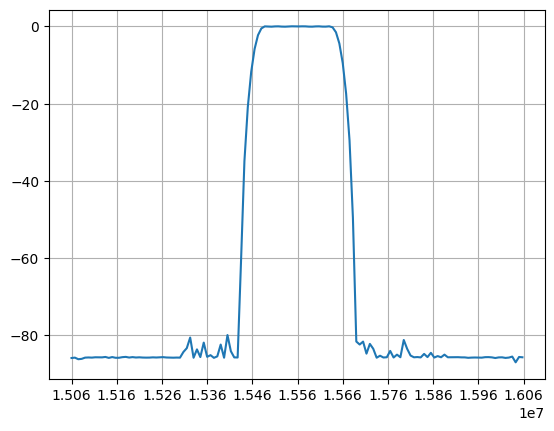

In [183]:
freq_l = (lo_freq) - 5e5
freq_h = (lo_freq) + 5e5
plt.grid()
plt.xticks(np.arange(freq_l, freq_h+1, 1e5))
plt.plot(freqs_to_scan[(freqs_to_scan >= freq_l) & (freqs_to_scan <= freq_h)], attenuation_dbs[(freqs_to_scan >= freq_l) & (freqs_to_scan <= freq_h)])